In [1]:
%config IPCompleter.use_jedi = False
# %xmode Verbose
# %xmode context
%pdb off
# %load_ext viztracer
# from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from pathlib import Path

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
# from numba import jit
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
# pd.options.mode.dtype_backend = 'pyarrow' # use new pyarrow backend instead of numpy
from attrs import define, field, fields, Factory
import tables as tb
from datetime import datetime, timedelta

# Pho's Formatting Preferences
import builtins

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython

from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
set_pho_preferences_concise()
# Jupyter-lab enable printing for any line on its own (instead of just the last one in the cell)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# BEGIN PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #


## IPython pprint
from pyphocorehelpers.pprint import wide_pprint, wide_pprint_ipython, wide_pprint_jupyter, MAX_LINE_LENGTH

# Override default pprint
builtins.pprint = wide_pprint

text_formatter: PlainTextFormatter = IPython.get_ipython().display_formatter.formatters['text/plain']
text_formatter.max_width = MAX_LINE_LENGTH
text_formatter.for_type(object, wide_pprint_jupyter)

import IPython
from IPython.core.formatters import PlainTextFormatter
from IPython import get_ipython
from IPython.display import display
# from pho_jupyter_preview_widget.display_helpers import array_repr_with_graphical_preview
from pho_jupyter_preview_widget.ipython_helpers import PreviewWidgetMagics

ip = get_ipython()

# Register the magic
ip.register_magics(PreviewWidgetMagics)

# # from pyphocorehelpers.ipython_helpers import MyMagics
# # %config_ndarray_preview width=500

# # Register the custom display function for NumPy arrays
# ip = array_repr_with_graphical_preview(ip=ip)



# END PPRINT CUSTOMIZATION ___________________________________________________________________________________________ #

from pyphocorehelpers.print_helpers import get_now_time_str, get_now_day_str

## Pho's Custom Libraries:
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path, file_uri_from_path
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from typing import Dict, List, Tuple, Optional, Callable, Union, Any
from typing_extensions import TypeAlias
from nptyping import NDArray
import neuropy.utils.type_aliases as types

from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.utils.matplotlib_helpers import matplotlib_file_only, matplotlib_configuration, matplotlib_configuration_update
from neuropy.core.neuron_identities import NeuronIdentityTable, neuronTypesList, neuronTypesEnum
from neuropy.utils.mixins.AttrsClassHelpers import AttrsBasedClassHelperMixin, serialized_field, serialized_attribute_field, non_serialized_field, custom_define
from neuropy.utils.mixins.HDF5_representable import HDF_DeserializationMixin, post_deserialize, HDF_SerializationMixin, HDFMixin, HDF_Converter

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.neurons import NeuronType
from neuropy.core.user_annotations import UserAnnotationsManager
from neuropy.core.position import Position
from neuropy.core.session.dataSession import DataSession
from neuropy.analyses.time_dependent_placefields import PfND_TimeDependent, PlacefieldSnapshot
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_subsession_neuron_differences, debug_print_ratemap, debug_print_spike_counts, debug_plot_2d_binning, print_aligned_columns
from neuropy.utils.debug_helpers import parameter_sweeps, _plot_parameter_sweep, compare_placefields_info
from neuropy.utils.indexing_helpers import NumpyHelpers, union_of_arrays, intersection_of_arrays, find_desired_sort_indicies, paired_incremental_sorting
from pyphocorehelpers.print_helpers import print_object_memory_usage, print_dataframe_memory_usage, print_value_overview_only, DocumentationFilePrinter, print_keys_if_possible, generate_html_string, document_active_variables

## Pho Programming Helpers:
import inspect
from pyphocorehelpers.print_helpers import DocumentationFilePrinter, TypePrintMode, print_keys_if_possible, debug_dump_object_member_shapes, print_value_overview_only, document_active_variables
from pyphocorehelpers.programming_helpers import IPythonHelpers, PythonDictionaryDefinitionFormat, MemoryManagement, inspect_callable_arguments, get_arguments_as_optional_dict, GeneratedClassDefinitionType, CodeConversion
from pyphocorehelpers.gui.Qt.TopLevelWindowHelper import TopLevelWindowHelper, print_widget_hierarchy
from pyphocorehelpers.indexing_helpers import reorder_columns, reorder_columns_relative, dict_to_full_array
from pyphocorehelpers.programming_helpers import CodeConversion, SourceCodeParsing, GeneratedClassDefinitionType

# doc_output_parent_folder: Path = Path('EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation').resolve() # ../.
# print(f"doc_output_parent_folder: {doc_output_parent_folder}")
# assert doc_output_parent_folder.exists()

# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_load_session, batch_extended_computations, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

import pyphoplacecellanalysis.External.pyqtgraph as pg

from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_perform_all_plots
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _find_any_context_neurons
from pyphoplacecellanalysis.General.Batch.runBatch import BatchSessionCompletionHandler # for `post_compute_validate(...)`
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import BasePositionDecoder
from pyphoplacecellanalysis.SpecificResults.AcrossSessionResults import AcrossSessionsResults
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends # for `_perform_long_short_instantaneous_spike_rate_groups_analysis`
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import SingleBarResult, InstantaneousSpikeRateGroupsComputation, TruncationCheckingResults # for `BatchSessionCompletionHandler`, `AcrossSessionsAggregator`
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DirectionalPlacefieldGlobalComputationFunctions, DirectionalLapsResult, TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderGlobalComputationFunctions
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import TrackTemplates
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderComputationsContainer, RankOrderResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.RankOrderComputations import RankOrderAnalyses


# Plotting
# import pylustrator # customization of figures
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
_bak_rcParams = mpl.rcParams.copy()

matplotlib.use('Qt5Agg')
# %matplotlib inline
# %matplotlib auto

# _restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')
_restore_previous_matplotlib_settings_callback = matplotlib_configuration_update(is_interactive=True, backend='Qt5Agg')

from silx.gui import qt
from silx.gui.plot import Plot2D, Plot1D
from silx.gui.colors import Colormap
from silx.gui.plot.items import ImageBase

# import pylustrator # call `pylustrator.start()` before creating your first figure in code.
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap_pyqtgraph # used in `plot_kourosh_activity_style_figure`
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import plot_multiple_raster_plot, plot_raster_plot
from pyphoplacecellanalysis.General.Mixins.DataSeriesColorHelpers import UnitColoringMode, DataSeriesColorHelpers
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.SpikeRasters import _build_default_tick, build_scatter_plot_kwargs
from pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.Mixins.Render2DScrollWindowPlot import Render2DScrollWindowPlotMixin, ScatterItemData
from pyphoplacecellanalysis.General.Batch.NonInteractiveProcessing import batch_extended_programmatic_figures, batch_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.SpikeAnalysis import SpikeRateTrends
from pyphoplacecellanalysis.General.Mixins.SpikesRenderingBaseMixin import SpikeEmphasisState

from pyphoplacecellanalysis.SpecificResults.PhoDiba2023Paper import PAPER_FIGURE_figure_1_add_replay_epoch_rasters, PAPER_FIGURE_figure_1_full, PAPER_FIGURE_figure_3, main_complete_figure_generations
from pyphoplacecellanalysis.SpecificResults.fourthYearPresentation import *
from pyphoplacecellanalysis.SpecificResults.PendingNotebookCode import SerializationHelper_AllCustomDecodingResults, SerializationHelper_CustomDecodingResults
    
# Jupyter Widget Interactive
import ipywidgets as widgets
from IPython.display import display, HTML
from pyphocorehelpers.Filesystem.open_in_system_file_manager import reveal_in_system_file_manager
from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import interactive_pipeline_widget, interactive_pipeline_files
from pyphocorehelpers.gui.Jupyter.simple_widgets import fullwidth_path_widget, render_colors

from datetime import datetime, date, timedelta
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_rounded_time_str

DAY_DATE_STR: str = date.today().strftime("%Y-%m-%d")
DAY_DATE_TO_USE = f'{DAY_DATE_STR}' # used for filenames throught the notebook
print(f'DAY_DATE_STR: {DAY_DATE_STR}, DAY_DATE_TO_USE: {DAY_DATE_TO_USE}')

NOW_DATETIME: str = get_now_rounded_time_str()
NOW_DATETIME_TO_USE = f'{NOW_DATETIME}' # used for filenames throught the notebook
print(f'NOW_DATETIME: {NOW_DATETIME}, NOW_DATETIME_TO_USE: {NOW_DATETIME_TO_USE}')


from pyphocorehelpers.gui.Jupyter.simple_widgets import build_global_data_root_parent_path_selection_widget
all_paths = [Path('/Volumes/SwapSSD/Data'), Path('/Users/pho/data'), Path(r'/media/MAX/Data'), Path(r'/media/halechr/MAX/Data'), Path(r'/home/halechr/FastData'), Path(r'W:\Data'), Path(r'/home/halechr/cloud/turbo/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data')]
global_data_root_parent_path = None
def on_user_update_path_selection(new_path: Path):
    global global_data_root_parent_path
    new_global_data_root_parent_path = new_path.resolve()
    global_data_root_parent_path = new_global_data_root_parent_path
    print(f'global_data_root_parent_path changed to {global_data_root_parent_path}')
    assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"
            
global_data_root_parent_path_widget = build_global_data_root_parent_path_selection_widget(all_paths, on_user_update_path_selection)
global_data_root_parent_path_widget

from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring, compute_local_peak_probabilities, get_peaks_mask, expand_peaks_mask, InversionCount, is_valid_sequence_index, SubsequencesPartitioningResult
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import _compute_diffusion_value

Automatic pdb calling has been turned OFF
DAY_DATE_STR: 2025-01-22, DAY_DATE_TO_USE: 2025-01-22
NOW_DATETIME: 2025-01-22_1248PM, NOW_DATETIME_TO_USE: 2025-01-22_1248PM
global_data_root_parent_path changed to W:\Data


In [2]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyphoplacecellanalysis.External.pyqtgraph.Qt import QtGui, QtCore, QtWidgets
# from pyphoplacecellanalysis.External.pyqtgraph.parametertree.parameterTypes.file import popupFilePicker
from pyphoplacecellanalysis.External.pyqtgraph.widgets.FileDialog import FileDialog

from silx.gui import qt
from silx.gui.dialog.ImageFileDialog import ImageFileDialog
from silx.gui.dialog.DataFileDialog import DataFileDialog
import silx.io

from pyphoplacecellanalysis.GUI.IPyWidgets.pipeline_ipywidgets import saveFile

from pyphoplacecellanalysis.General.Pipeline.Stages.Loading import loadData

from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.DirectionalPlacefieldGlobalComputationFunctions import DecoderDecodedEpochsResult
from pyphoplacecellanalysis.GUI.Silx.EpochHeuristicPosteriorDebuggerWidget import EpochHeuristicDebugger

# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-02-13_CustomDecodingResults.pkl").resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-02-13_9pm_CustomDecodingResults.pkl").resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-02-14_CustomDecodingResults.pkl").resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\output\2024-02-15_CustomDecodingResults.pkl").resolve()
# load_path = Path("/media/halechr/MAX/Data/KDIBA/gor01/one/2006-6-08_14-26-15/output/2024-02-15_CustomDecodingResults.pkl").resolve()
# load_path = Path("/Users/pho/data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-02-16_CustomDecodingResults.pkl").resolve()
# load_path = Path("/Users/pho/data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-02-14_CustomDecodingResults.pkl").resolve()
# load_path = Path("/Users/pho/data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-04-25_CustomDecodingResults.pkl").resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-04-25_CustomDecodingResults.pkl").resolve() # APOGEE
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-04-28_CustomDecodingResults.pkl").resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\two\2006-6-09_22-24-40\output\2024-04-28_CustomDecodingResults.pkl").resolve() # APOGEE
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-09_1-22-43\output\2024-04-28_CustomDecodingResults.pkl").resolve()
# load_path = Path('W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-11-25_CustomDecodingResults.pkl').resolve()
# load_path = Path(r"W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\output\2024-05-06_CustomDecodingResults.pkl").resolve() # new relative format

# load_path = Path('/media/halechr/MAX/Data/KDIBA/gor01/one/2006-6-08_14-26-15/output/2024-08-01_CustomDecodingResults.pkl').resolve() # LAB

# load_path = Path('W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-11-25_CustomDecodingResults.pkl').resolve()
# directional_decoders_epochs_decode_result, xbin, xbin_centers =  SerializationHelper_CustomDecodingResults.load(load_path=load_path)


load_path = Path("W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-11-25_AllCustomDecodingResults.pkl")
track_templates, directional_decoders_epochs_decode_result, xbin, xbin_centers =  SerializationHelper_AllCustomDecodingResults.load(load_path=load_path)
pos_bin_size = directional_decoders_epochs_decode_result.pos_bin_size


Computing loaded session pickle file results : "W:/Data/KDIBA/gor01/one/2006-6-09_1-22-43/output/2024-11-25_AllCustomDecodingResults.pkl"... done.
xbin_centers: [38.9801 42.7855 46.5909 50.3963 54.2018 58.0072 61.8126 65.618 69.4234 73.2289 77.0343 80.8397 84.6451 88.4505 92.2559 96.0614 99.8668 103.672 107.478 111.283 115.088 118.894 122.699 126.505 130.31 134.116 137.921 141.726 145.532 149.337 153.143 156.948 160.753 164.559 168.364 172.17 175.975 179.781 183.586 187.391 191.197 195.002 198.808 202.613 206.418 210.224 214.029 217.835 221.64 225.446 229.251 233.056 236.862 240.667 244.473 248.278 252.083]


In [4]:


# epoch_type_selector_dict = {'laps': {'decoder_filter_epochs_decoder_result_dict': decoder_laps_filter_epochs_decoder_result_dict, #'decoder_laps_radon_transform_df_dict': decoder_laps_radon_transform_df_dict,
#           'decoder_radon_transform_extras_dict': decoder_laps_radon_transform_extras_dict},
# 'ripple': {'decoder_filter_epochs_decoder_result_dict': decoder_ripple_filter_epochs_decoder_result_dict, #'decoder_laps_radon_transform_df_dict': decoder_laps_radon_transform_df_dict,
#           'decoder_radon_transform_extras_dict': decoder_ripple_radon_transform_extras_dict},
# }

from neuropy.utils.indexing_helpers import NumpyHelpers, PandasHelpers
from pyphoplacecellanalysis.Pho2D.track_shape_drawing import get_track_length_dict

a_decoded_filter_epochs_decoder_result_dict: Dict[str, DecodedFilterEpochsResult] = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict)

## INPUTS: track_templates, a_decoded_filter_epochs_decoder_result_dict
decoder_grid_bin_bounds_dict = {a_name:a_decoder.pf.config.grid_bin_bounds for a_name, a_decoder in track_templates.get_decoders_dict().items()}
assert NumpyHelpers.all_allclose(list(decoder_grid_bin_bounds_dict.values())), f"all decoders should have the same grid_bin_bounds (independent of whether they are built on long/short, etc but they do not! This violates following assumptions."
grid_bin_bounds = list(decoder_grid_bin_bounds_dict.values())[0] # tuple
actual_track_length_dict, idealized_track_length_dict = get_track_length_dict(grid_bin_bounds, grid_bin_bounds)
# idealized_track_length_dict # {'long': 214.0, 'short': 144.0}
decoder_track_length_dict = {a_name:idealized_track_length_dict[a_name.split('_', maxsplit=1)[0]] for a_name, a_result in a_decoded_filter_epochs_decoder_result_dict.items()} # 
decoder_track_length_dict # {'long_LR': 214.0, 'long_RL': 214.0, 'short_LR': 144.0, 'short_RL': 144.0}
## OUTPUTS: decoder_track_length_dict
        

a_name: str = 'long_LR'
# a_decoder_decoded_epochs_result: DecodedFilterEpochsResult = deepcopy(directional_decoders_epochs_decode_result.decoder_laps_filter_epochs_decoder_result_dict['long_LR'])
a_decoder_decoded_epochs_result: DecodedFilterEpochsResult = deepcopy(directional_decoders_epochs_decode_result.decoder_ripple_filter_epochs_decoder_result_dict[a_name])
a_decoder_track_length: float = decoder_track_length_dict[a_name]
a_decoder_decoded_epochs_result
good_epochs_list = [12, 15, 28, 37]


a_decoded_filter_epochs_decoder_result_dict, _out_new_scores, partition_result_dict = HeuristicReplayScoring.compute_all_heuristic_scores(track_templates=track_templates, a_decoded_filter_epochs_decoder_result_dict=a_decoded_filter_epochs_decoder_result_dict)
all_score_computations_fn_dict = HeuristicReplayScoring.build_all_score_computations_fn_dict()



{'long_LR': 214.0, 'long_RL': 214.0, 'short_LR': 144.0, 'short_RL': 144.0}

DecodedFilterEpochsResult(decoding_time_bin_size: float,
	filter_epochs: pandas.core.frame.DataFrame,
	num_filter_epochs: int,
	most_likely_positions_list: list | shape (n_epochs),
	p_x_given_n_list: list | shape (n_epochs),
	marginal_x_list: list | shape (n_epochs),
	marginal_y_list: list | shape (n_epochs),
	most_likely_position_indicies_list: list | shape (n_epochs),
	spkcount: list | shape (n_epochs),
	nbins: numpy.ndarray | shape (n_epochs),
	time_bin_containers: list | shape (n_epochs),
	time_bin_edges: list | shape (n_epochs),
	epoch_description_list: list | shape (n_epochs),
	pos_bin_edges: NoneType | shape (n, _, p, o, s, _, b, i, n, s, +, 1)
)

c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-pac

In [5]:

app = pg.mkQApp('Heuristic Analysis Explorer')


## add custom bin_by_bin fn:

In [6]:
from numpy import ma


@function_attributes(short_name='large_jump_excluding', tags=['bin-by-bin', 'score', 'replay'], input_requires=[], output_provides=[], uses=[], used_by=[], creation_date='2024-11-25 11:39', related_items=[])
def bin_by_bin_large_jump_filtering_fn(a_result: DecodedFilterEpochsResult, an_epoch_idx: int, a_decoder_track_length: float) -> Tuple[NDArray, NDArray]:
    """
    """
    max_position_jump_distance_cm: float = 50.0
    # max_position_jump_velocity_cm_per_sec: float = 0.3
    
    time_window_centers, bin_by_bin_jump_distance = HeuristicReplayScoring.bin_by_bin_position_jump_distance(a_result=a_result, an_epoch_idx=an_epoch_idx, a_decoder_track_length=a_decoder_track_length)
    assert len(time_window_centers) == len(bin_by_bin_jump_distance)
    ## convert to cm/sec (jump velocity) by dividing by time_bin_size
    # bin_by_bin_jump_velocity = deepcopy(bin_by_bin_jump_distance) / time_window_centers
    is_included_idx = (np.abs(bin_by_bin_jump_distance) <= max_position_jump_distance_cm)
     
    arr_masked = ma.masked_array(bin_by_bin_jump_distance, mask=np.logical_not(is_included_idx), fill_value=np.nan)
    time_window_centers_arr_masked = ma.masked_array(time_window_centers, mask=np.logical_not(is_included_idx), fill_value=np.nan)

    return time_window_centers_arr_masked, arr_masked


all_bin_by_bin_computation_fn_dict = HeuristicReplayScoring.build_all_bin_by_bin_computation_fn_dict()
all_bin_by_bin_computation_fn_dict.update({
    'large_jump_excluding': bin_by_bin_large_jump_filtering_fn, 
})
all_bin_by_bin_computation_fn_dict


{'jump_cm_per_sec': <bound method HeuristicReplayScoring.bin_by_bin_position_jump_velocity of <class 'pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring.HeuristicReplayScoring'>>,
 'large_jump_excluding': <function __main__.bin_by_bin_large_jump_filtering_fn(a_result: pyphoplacecellanalysis.Analysis.Decoder.reconstruction.DecodedFilterEpochsResult, an_epoch_idx: int, a_decoder_track_length: float) -> Tuple[npndarray.NDArray, npndarray.NDArray]>}

In [ ]:
dbgr.all_bin_by_bin_computation_fn_dict.update({
'large_jump_excluding': bin_by_bin_large_jump_filtering_fn, 
})
dbgr.programmatically_update_active_epoch(28)

## Program Goal: Find the longest possible subsequence such that none of the following requirements are violated:
1. the `candidate_subsequence` contains no intruding subsequence with length longer than `max_ignore_bins` bins  
2. the total number of intruding subsequence time bins does not exceed `(len(candidate_subsequence)/2.0)` -- "more sequence bins than intruding bins"
maxbridged

## 2024-05-03 Heuristic 
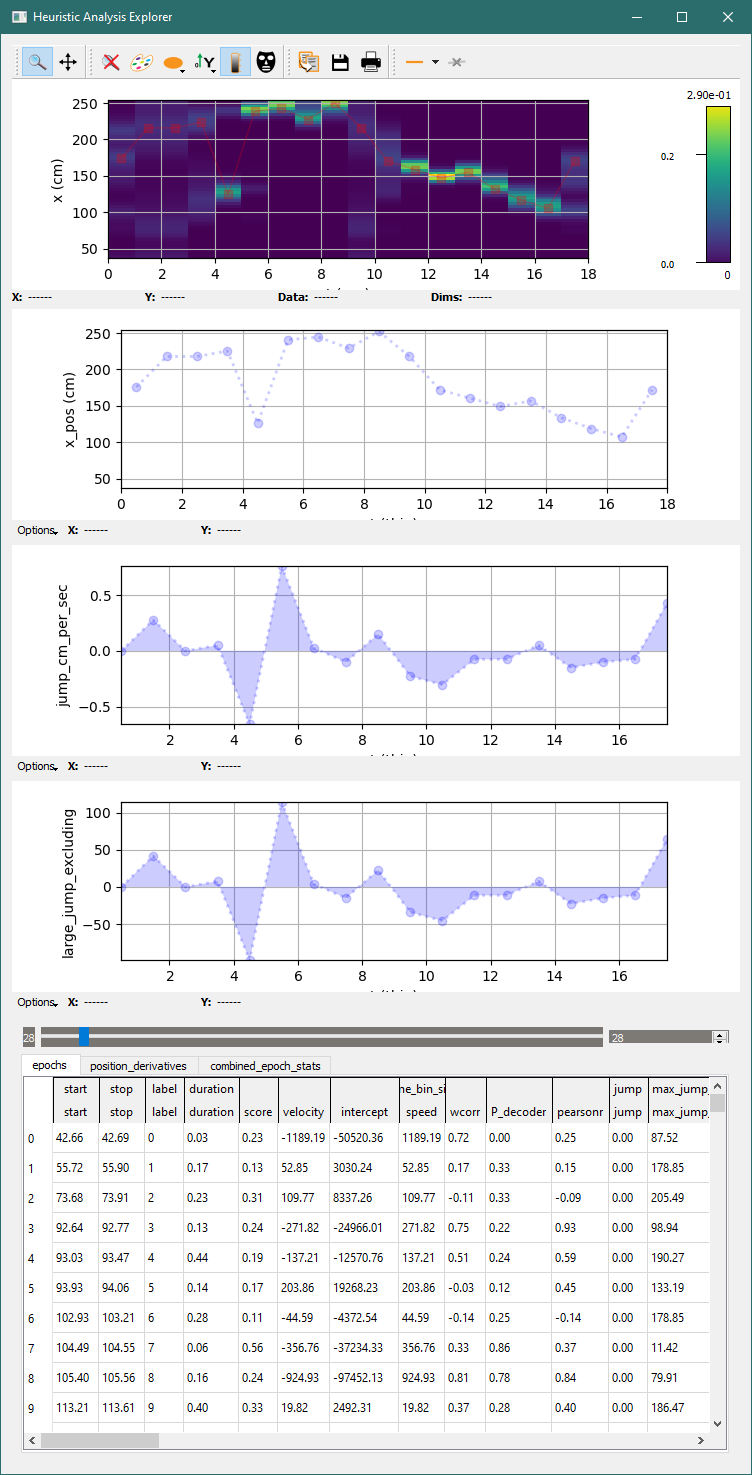

In [ ]:
from pyphoplacecellanalysis.GUI.Silx.EpochHeuristicPosteriorDebuggerWidget import EpochHeuristicDebugger
from pyphoplacecellanalysis.GUI.Silx.EpochHeuristicPosteriorDebuggerWidget import PositionDerivativesContainer
from pyphoplacecellanalysis.GUI.Qt.Widgets.ScrollBarWithSpinBox.ScrollBarWithSpinBox import ScrollBarWithSpinBox

initial_epoch_idx: int = 28 # 55, 12 is also good
dbgr: EpochHeuristicDebugger = EpochHeuristicDebugger.init_from_epoch_idx(a_decoder_decoded_epochs_result=a_decoder_decoded_epochs_result, active_epoch_idx=initial_epoch_idx,
									pos_bin_size=pos_bin_size, decoder_track_length=a_decoder_track_length, xbin=deepcopy(xbin), xbin_centers=deepcopy(xbin_centers),
                                    all_bin_by_bin_computation_fn_dict = all_bin_by_bin_computation_fn_dict,
									use_bin_units_instead_of_realworld=False, 
									)

slider = widgets.IntSlider(value=initial_epoch_idx, min=0, max=(a_decoder_decoded_epochs_result.num_filter_epochs-1))
slider.observe(dbgr.on_slider_change, names='value')
display(slider)

n_global_xbin_pos_bins: 57
n_tbins: 18, n_pos_bins: 57
x_range: 216.90877564079906, img_height_scale: 3.8054171165052466
img_origin: (0.0, 37.0773897438341)
img_scale: (1.0, 3.8054171165052466)
img_bounds: ((0, 18), (37.0773897438341, 253.98616538463315))
curr_img_bounds: ((0.0, 18.0), (37.0773897438341, 253.98616538463315))
curr_img_bounds: ((0.0, 18.0), (37.0773897438341, 253.98616538463315))
WARN: self.disable_emit_changed = True
WARN: self.disable_emit_changed = True
n_global_xbin_pos_bins: 57
n_tbins: 18, n_pos_bins: 57
n_global_xbin_pos_bins: 57
n_tbins: 18, n_pos_bins: 57
x_range: 216.90877564079906, img_height_scale: 3.8054171165052466
img_origin: (0.0, 37.0773897438341)
img_scale: (1.0, 3.8054171165052466)
img_bounds: ((0, 18), (37.0773897438341, 253.98616538463315))


IntSlider(value=28, max=411)

n_global_xbin_pos_bins: 57
n_tbins: 15, n_pos_bins: 57
n_global_xbin_pos_bins: 57
n_tbins: 15, n_pos_bins: 57
x_range: 216.90877564079906, img_height_scale: 3.8054171165052466
img_origin: (0.0, 37.0773897438341)
img_scale: (1.0, 3.8054171165052466)
img_bounds: ((0, 15), (37.0773897438341, 253.98616538463315))
n_global_xbin_pos_bins: 57
n_tbins: 17, n_pos_bins: 57
n_global_xbin_pos_bins: 57
n_tbins: 17, n_pos_bins: 57
x_range: 216.90877564079906, img_height_scale: 3.8054171165052466
img_origin: (0.0, 37.0773897438341)
img_scale: (1.0, 3.8054171165052466)
img_bounds: ((0, 17), (37.0773897438341, 253.98616538463315))
n_global_xbin_pos_bins: 57
n_tbins: 6, n_pos_bins: 57
n_global_xbin_pos_bins: 57
n_tbins: 6, n_pos_bins: 57
x_range: 216.90877564079906, img_height_scale: 3.8054171165052466
img_origin: (0.0, 37.0773897438341)
img_scale: (1.0, 3.8054171165052466)
img_bounds: ((0, 6), (37.0773897438341, 253.98616538463315))
n_global_xbin_pos_bins: 57
n_tbins: 13, n_pos_bins: 57
n_global_xbin_p

In [ ]:
plot: Plot2D = dbgr.plot
plot.resetZoom()

In [ ]:
# dbgr.programmatic_plots_config_dict
dbgr.programmatic_plots_dict


In [ ]:
## INPUTS: dbgr, dbgr
new_col_name: str = 'large_jump_excluding'
dbgr.all_bin_by_bin_computation_fn_dict.update({
'large_jump_excluding': bin_by_bin_large_jump_filtering_fn, 
})


## Build a new plot if needed
a_plot, a_plot_config_dict = EpochHeuristicDebugger._perform_initialize_new_plot_and_config_if_needed(dbgr=dbgr, a_plot_name=new_col_name)
assert a_plot is not None
assert a_plot_config_dict is not None

dbgr.main_layout.addWidget(a_plot) ## add the plot to the main_layout

# for a_plot_name, a_plot in dbgr.programmatic_plots_dict.items():
#     dbgr.main_layout.addWidget(a_plot) ## add the plot to the main_layout


In [ ]:
plot_position: Plot1D = dbgr.plot_position
# plot_position.setXAxisAutoScale(flag=True)

xmin, xmax = xbin[0], xbin[-1]
(xmin, xmax)

plot_position.getXAxis().setLimits(xmin, xmax)

plot_position.getXAxis().getLimits()

In [ ]:
243 - 129 # 114

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import SingleEpochDecodedResult

active_single_epoch_result: SingleEpochDecodedResult = dbgr.active_single_epoch_result
active_single_epoch_result

active_single_epoch_result.epoch_info_tuple

In [ ]:
epoch_start_time=149.959

# dbgr.filter_epochs
# dbgr.active_decoder_decoded_epochs_result.get_result_for_epoch_at_time(epoch_start_time=epoch_start_time)

# filtered_v = deepcopy(dbgr.active_decoder_decoded_epochs_result).filtered_by_epoch_times(included_epoch_start_times=np.atleast_1d(epoch_start_time)) # should only have 1 epoch remaining
# assert len(filtered_v.filter_epochs) == 1, f"len(filtered_v.filter_epochs): {len(filtered_v.filter_epochs)}"
# _out_epoch_result = filtered_v.get_result_for_epoch(active_epoch_idx=0) # 0 to indicate the first (and only) remaining epoch
# _out_epoch_result.epoch_info_tuple # EpochTuple(Index=28, start=149.95935746072792, stop=150.25439218967222, label=28, duration=0.2950347289443016, score=0.21180153240310493, velocity=731.810983943322, intercept=110046.67878251396, speed=731.810983943322, wcorr=-0.3284489944870443, P_decoder=0.2557134631770172, pearsonr=-0.5097636509078233, travel=0.14539664079005754, coverage=0.45614035087719296, jump=0.0025033377837116156, max_jump=114.1625134951574, sequential_correlation=2127831.2413223204, monotonicity_score=2127831.2413223204, laplacian_smoothness=2127831.2413223204, longest_sequence_length=4, longest_sequence_length_ratio=0.2222222222222222, direction_change_bin_ratio=0.47058823529411764, congruent_dir_bins_ratio=0.5294117647058824, total_congruent_direction_change=266.3791981553672, total_variation=528.9529791942293, integral_second_derivative=84280.58068604024, stddev_of_diff=44.75058200479833, is_user_annotated_epoch=True, is_valid_epoch=True, session_name='2006-6-09_1-22-43', delta_aligned_start_t=-879.357251301175, pre_post_delta_category='pre-delta', maze_id=0)
# # _out_epoch_result.epoch_data_index

# epoch_time_to_index_map = deepcopy(dbgr.active_decoder_decoded_epochs_result).filter_epochs.epochs.find_epoch_times_to_data_indicies_map(epoch_times=[epoch_start_time, ])
epoch_time_to_index_map = dbgr.find_epoch_times_to_data_indicies_map(epoch_times=[epoch_start_time, ])
if len(epoch_time_to_index_map) > 0:
    found_idxs = list(epoch_time_to_index_map.values())
    a_found_idx: int = found_idxs[0]
    print(f'epoch_start_time: {epoch_start_time}\na_found_idx: {a_found_idx}')
    # slider.value = a_found_idx
    # dbgr.update_active_epoch_data(active_epoch_idx=a_found_idx)
    # active_epoch_scrollbar_ctrl_widget: ScrollBarWithSpinBox = dbgr.ui['ctrls_widget']
    # active_epoch_scrollbar_ctrl_widget.setValue(28)
    # active_epoch_scrollbar_ctrl_widget.emitChanged()
    dbgr.programmatically_update_active_epoch(active_epoch_idx=a_found_idx)

# epoch_time_to_index_map


In [ ]:
slider.value = 28
dbgr.update_active_epoch_data(active_epoch_idx=28)


In [ ]:
dbgr.plot.mask()


## INPUTS: debgr
img_data = dbgr.plot.getActiveImage() # ImageData
curr_posterior: NDArray = deepcopy(img_data.getData())
curr_selection_mask: NDArray = deepcopy(dbgr.plot.getSelectionMask())
assert np.shape(curr_posterior) == np.shape(curr_selection_mask)
curr_selection_indicies = np.where(curr_selection_mask == 1)
len(curr_selection_indicies[0])
curr_selection_indicies

In [ ]:
source_selection_mask = deepcopy(curr_selection_mask)
source_selection_indicies = deepcopy(np.where(source_selection_mask == 1))
source_selection_values = deepcopy(curr_posterior[source_selection_indicies])
# source_selection_values.shape
# source_selection_mask
source_selection_indicies
source_selection_values


In [ ]:
source_selection_values

In [ ]:
dest_selection_mask = deepcopy(curr_selection_mask)
dest_selection_indicies = deepcopy(curr_selection_indicies)
dest_original_selection_values = deepcopy(curr_posterior[dest_selection_indicies]) # the values that will be overwritten with the source

dest_selection_indicies
dest_original_selection_values

In [ ]:
from attrs import asdict
longest_sequence_length, longest_sequence_length_ratio, direction_change_bin_ratio, congruent_dir_bins_ratio, total_congruent_direction_change, total_variation, integral_second_derivative, stddev_of_diff, position_derivatives_df = dbgr.heuristic_scores

heuristic_scores_dict = asdict(dbgr.heuristic_scores, filter=lambda a, v: a.name not in ['position_derivatives_df'])
# heuristic_scores_dict
# longest_sequence_length

df = pd.DataFrame(list(heuristic_scores_dict.values()), index=heuristic_scores_dict.keys(), columns=['Values'])
print(df)


In [ ]:
from pyphocorehelpers.gui.Qt.pandas_model import SimplePandasModel

## INPUTS: df

# Update the table:
table_id_name: str = 'combined_epoch_stats'
dbgr.ui.models_dict[table_id_name] = SimplePandasModel(df.copy())

# Update the view's model:
view = dbgr.ui.views_dict[table_id_name]
view.setModel(dbgr.ui.models_dict[table_id_name])
# Adjust the column widths to fit the contents
view.resizeColumnsToContents()


In [ ]:
tables_tab_widget = dbgr.ui.tables_tab_widget
tables_tab_widget.setMinimumHeight(500)


In [ ]:
## overwrite
assert np.shape(dest_original_selection_values) == np.shape(source_selection_values)
modified_posterior = deepcopy(curr_posterior)
modified_posterior[dest_selection_indicies] = 0.666 # source_selection_values.copy()
# modified_posterior

# img_data.setData(modified_posterior)

# curr_posterior - modified_posterior

In [ ]:
# dbgr.plot.addImage(modified_posterior)
prev_img = dbgr.plot.getImage('p_x_given_n') # ImageBase
prev_img.setData(modified_posterior)
# dbgr.plot.setActiveImage('p_x_given_n')

In [ ]:
dbgr.plot.removeImage()

In [ ]:
## Use the selection mask as the "clone" source
# curr_posterior
mask_tools = dbgr.plot.getMaskToolsDockWidget()
# mask_tools.getSelectionMask()
# mask_tools.


In [ ]:
## Tries to display the plot2D posterior heatmap as a 3D surface plot for easier visualization, but it doesn't work

from silx.gui import qt
from silx.gui.plot3d.SceneWindow import SceneWindow
from silx.gui.plot3d import SceneWidget

## INPUTS: plot2D

plot2D = dbgr.plot

# Extract image data from the existing Plot2D instance
item = plot2D.getActiveImage()
if item is None:
    raise ValueError("No active image in the provided Plot2D instance")
image_data = item.getData(copy=False)

# Create a surface plot from the image data
x = np.arange(image_data.shape[1])
y = np.arange(image_data.shape[0])
x, y = np.meshgrid(x, y)
z = image_data

# Create and set up the 3D plot window
# Create a SceneWindow widget
plot3DWindow = SceneWindow()

# Get the SceneWidget contained in the window and set its colors
plot3D = plot3DWindow.getSceneWidget()
plot3D.setBackgroundColor((0.8, 0.8, 0.8, 1.0))
plot3D.setForegroundColor((1.0, 1.0, 1.0, 1.0))
plot3D.setTextColor((0.1, 0.1, 0.1, 1.0))

# plot3D = plot3DWindow.sceneWidget()
plot3D.add
plot3D.addSurface(x, y, z)

# Show the 3D plot window
plot3DWindow.show()

In [ ]:
from pyphoplacecellanalysis.GUI.Silx.silx_helpers import ContinuousImageMask, ContinuousMaskToolsWidget, ContinuousMaskToolsDockWidget, getMaskToolsDockWidget

# dbgr.plot.getMaskToolsDockWidget = getMaskToolsDockWidget

## Adds a new mask bar at the bottom of the widget:

# if mask is None:
#     if self.__useMaskButton.isChecked():
#         mask = self.__plot.getMaskToolsDockWidget().getSelectionMask()


new_maskToolsWidget: ContinuousMaskToolsWidget = ContinuousMaskToolsWidget(
    plot=dbgr.plot, parent=dbgr.main_widget,
)


new_maskToolsWidget

dbgr.main_layout.addWidget(new_maskToolsWidget)

# getMaskToolsDockWidget

In [ ]:
new_maskToolsWidget.pencilSetting.setVisible(True)

In [ ]:
new_maskToolsWidget._drawingMode

In [ ]:
new_maskToolsWidget._updateDrawingModeWidgets()

In [ ]:
new_maskToolsWidget.plot

In [ ]:
new_maskToolsWidget._activePencilMode() # setInteractiveMode

In [ ]:
new_maskToolsWidget.clearMask()

In [ ]:
_out = getMaskToolsDockWidget(dbgr.plot.) # dbgr.plot.getMaskToolsDockWidget()
_out

In [ ]:
_out

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicScoresTuple

active_heuristic_scores:HeuristicScoresTuple = deepcopy(dbgr.heuristic_scores)

position_derivatives_df: pd.DataFrame = deepcopy(dbgr.heuristic_scores.position_derivatives_df)
longest_sequence_length = dbgr.heuristic_scores.longest_sequence_length

position_derivatives_df

In [ ]:
# active_heuristic_scores

dbgr.active_decoder_decoded_epochs_result.filter_epochs

In [ ]:
filter_epochs_df = deepcopy(dbgr.active_decoder_decoded_epochs_result.filter_epochs)
filter_epochs_df['original_index'] = filter_epochs_df.index
# longest_sequence_length_ratio
active_heuristic_sort_measure = 'longest_sequence_length_ratio'
# active_heuristic_sort_measure = 'longest_sequence_length'


filter_epochs_df.sort_values(by=[active_heuristic_sort_measure, 'start', 'stop'], ascending=[False, True, True], inplace=True)
filter_epochs_df.reset_index(drop=True, inplace=True)
filter_epochs_df

original_indices_first_5 = filter_epochs_df['original_index'].head(5).tolist()
print(original_indices_first_5)

# [325, 222, 261, 14, 73]


In [ ]:
ui_dict = dbgr._build_utility_controls(main_layout=dbgr.main_layout)

In [ ]:
# a_plot: Plot1D = dbgr.plot_position
a_plot: Plot1D = dbgr.plot_velocity
# a_plot
# a_plot.set

In [ ]:
a_curve = dbgr.plot_velocity.getCurve("Velocity")


In [ ]:
k = 'Position'
# k = "Velocity"
a_plot: Plot1D = dbgr.position_plots_dict[k]
a_curve = a_plot.getCurve(k)
# a_curve.getSymbol() # 'o'
# a_curve.getSymbolSize() # 6.0
# a_curve.setSymbol('o')
# a_curve.setSymbolSize(6.0)

In [ ]:

_plot_toolbars = [a_plot.toolBar(), a_plot.getOutputToolBar(), a_plot.getInteractiveModeToolBar()]
for a_toolbar in _plot_toolbars:
	a_plot.removeToolBar(a_toolbar)
# a_plot.removeToolBarBreak()


In [ ]:
# a_plot.getItems()
a_plot.get

In [ ]:

a_plot.removeToolBar(a_plot.toolBar())


In [ ]:
current_baseline = numpy.zeros_like(edges)
a_curve.getBaseline

In [ ]:
# Draw stems manually
x = deepcopy(dbgr.position_derivatives._curve_vel_t)
y = deepcopy(dbgr.position_derivatives.vel)

_temp_curves = []
for i, xi, yi in zip(np.arange(len(x)), x, y):
	print(f'i: {i}, xi: {xi}, yi: {yi}')
	# _temp_curves.append(a_plot.addCurve([xi, xi], [0, yi], color='black', linestyle='-', linewidth=5))
    

In [ ]:
for v in _temp_curves:
	v.remove()


In [ ]:
, symbol='+', symbolSize=5

In [ ]:
main_plot: Plot2D = dbgr.plot
an_ax = main_plot.getYAxis()


In [ ]:
a_plot.toolBar().hide()
a_plot.


In [ ]:
from functools import partial
from pyphocorehelpers.print_helpers import DocumentationFilePrinter
from silx.gui.plot.stats.stats import StatBase
from silx.gui.utils import concurrent

from pyphoplacecellanalysis.GUI.Silx.silx_helpers import DebugPrinterStat, DispersionImageStat

    


In [ ]:

for a_plot_name, a_plot in dbgr.position_plots_dict.items():
	stats = [
		('sum', np.sum),
		# Integral(),
		# (COM(), '{0:.2f}'),
		# DebugPrinterStat(),
	]
	a_plot.getStatsWidget().setStats(stats)
	# a_plot.getStatsWidget().setUpdateMode(options.update_mode)
	a_plot.getStatsWidget().setDisplayOnlyActiveItem(False)
	a_plot.getStatsWidget().parent().setVisible(True)
	


In [ ]:
a_plot = dbgr.plot

stats = [
	# ('sum', np.sum),
	# Integral(),
	# (COM(), '{0:.2f}'),
	# DebugPrinterStat(),
	(DispersionImageStat(), '{0:.2f}'),
]

a_plot.getStatsWidget().setStats(stats)
# a_plot.getStatsWidget().setUpdateMode(options.update_mode)
a_plot.getStatsWidget().setDisplayOnlyActiveItem(False)
a_plot.getStatsWidget().parent().setVisible(True)



In [ ]:
a_plot.setXAxisAutoScale(flag=False)
a_plot.setYAxisAutoScale(flag=True)
a_plot.resetZoom()


In [ ]:
a_plot.getXAxis().setLimits(*x_range)

In [ ]:
a_plot.getActiveCurveStyle()._linestyle

In [ ]:
a_plot.setGraphGrid(which=True) # good
a_plot.setActiveCurve('Velocity')

# a_plot.setActiveCurveSelectionMode('none')
# a_plot.setActiveCurveSelectionMode('legacy')
# a_plot.setActiveCurve('Position')

In [ ]:
from silx.gui.plot.items.curve import Curve

a_curve: Curve = a_plot.getCurve("Position") # silx.gui.plot.items.curve.Curve
a_curve.getCurrentStyle() # silx.gui.plot.items.curve.CurveStyle
print_keys_if_possible('a_plot.getCurrentStyle()', a_curve.getCurrentStyle())

In [ ]:
a_curve.getCurrentStyle().__dict__

In [ ]:
a_curve.getLineStyle()

In [ ]:
a_curve.__dict__

In [ ]:
# a_plot.setLineStyle(
a_curve.getSupportedLineStyles()

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicScoresTuple, HeuristicReplayScoring

dbgr.heuristic_scores = HeuristicReplayScoring.compute_pho_heuristic_replay_scores(a_result=a_decoder_decoded_epochs_result, an_epoch_idx=dbgr.active_single_epoch_result.epoch_data_index, debug_print=False)

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicScoresTuple, HeuristicReplayScoring

HeuristicReplayScoring.bin_wise_continuous_sequence_sort_score_fn(a_result=a_decoder_decoded_epochs_result, an_epoch_idx=dbgr.active_single_epoch_result.epoch_data_index, a_decoder_track_length=170.0, same_thresh=4)

In [ ]:
dbgr.heuristic_scores

In [ ]:
# _curve_x = time_bin_centers
_curve_x = np.arange(len(max_path)) + 0.5 # move forward by a half bin

_max_path_Curve = dbgr.plot.addCurve(x=_curve_x, y=max_path, color='r', symbol='s', legend='max_path', replace=True, )
_max_path_Curve


In [ ]:
# def _my_split_list_fn(lst, accum, i, v):



from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import partition_subsequences_ignoring_same_positions

lst1 = [0, 3.80542, -3.80542, -19.0271, 0, -19.0271]
list_parts1, list_split_indicies1 = partition_subsequences_ignoring_same_positions(lst=lst1) # [[0, 3.80542, -3.80542, 0, -19.0271]]
list_parts1
list_split_indicies1

lst2 = [0, 3.80542, 5.0, -3.80542, -19.0271, 0, -19.0271]
list_parts2, list_split_indicies2 = partition_subsequences_ignoring_same_positions(lst=lst2) # [[0, 3.80542, -3.80542], [-19.0271, 0, -19.0271]]
list_parts2
list_split_indicies2

# lst1 = [0, 3.80542, -3.80542, -19.0271, 0, -19.0271]
# partition_subsequences(lst=lst1) # [[0, 3.80542, -3.80542, 0, -19.0271]]

# lst2 = [0, 3.80542, 5.0, -3.80542, -19.0271, 0, -19.0271]
# partition_subsequences(lst=lst2) # [[0, 3.80542, -3.80542], [-19.0271, 0, -19.0271]]


In [ ]:
np.ang

In [ ]:
from rdp import rdp

max_path = np.nanargmax(dbgr.p_x_given_n_masked, axis=0) # returns the x-bins that maximize the path
_curve_x = np.arange(len(max_path)) + 0.5 # move forward by a half bin
# _curve_y = np.arange(len(max_path)) + 0.5 # move forward by a half bin
# assert len(max_path) == len(time_bin_centers)
# _curve_x = time_bin_centers

# print(nfx)
points = np.column_stack([_curve_x, max_path])
print("points.shape:", points.shape)
points_after_rdp = rdp(points, epsilon=1)

# Graph
plt.figure(num='rdp trajectory fit', clear=True)
plt.plot(points_after_rdp[:, 0], points_after_rdp[:, 1], color="red", label="after RDP")
plt.plot(
    points[:, 0], points[:, 1], color="black", label="before", alpha=0.7, linewidth=1
)
plt.xlabel("time (s)")
plt.ylabel("Close")
plt.legend()
plt.show()

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import _compute_total_variation, _compute_integral_second_derivative, _compute_stddev_of_diff

max_path = np.nanargmax(dbgr.p_x_given_n_masked, axis=0) # returns the x-bins that maximize the path

_compute_total_variation(max_path)
_compute_integral_second_derivative(max_path)
_compute_stddev_of_diff(max_path)


In [ ]:
# change_angles = np.degrees(np.arctan2(np.diff(max_path), time_bin_size))
change_angles = np.degrees(np.arctan2(np.diff(max_path), 1))
change_angles




In [ ]:
import numpy
from silx.gui import qt
from silx.gui.fit import FitWidget
from silx.math.fit.functions import sum_gauss

# x = numpy.arange(2000).astype(numpy.float)
# constant_bg = 3.14

# # gaussian parameters: height, position, fwhm
# p = numpy.array([1000, 100., 30.0,
#                  500, 300., 25.,
#                  1700, 500., 35.,
#                  750, 700., 30.0,
#                  1234, 900., 29.5,
#                  302, 1100., 30.5,
#                  75, 1300., 75.])
# y = sum_gauss(x, *p) + constant_bg

x = _curve_x
y = max_path

# a = qt.QApplication([])

w = FitWidget()
w.setData(x=x, y=y)
w.show()

In [ ]:
## INPUTS: active_captured_single_epoch_result

In [ ]:
# *position_relative": mapped between the ends of the track, 0.0 to 1.0
most_likely_position_relative: NDArray = (np.squeeze(active_captured_single_epoch_result.most_likely_position_indicies) / float(active_captured_single_epoch_result.n_xbins-1))
most_likely_position_relative

plt.hlines([0], colors='k', xmin=active_captured_single_epoch_result.time_bin_edges[0], xmax=active_captured_single_epoch_result.time_bin_edges[-1])
plt.step(active_captured_single_epoch_result.time_bin_container.centers[1:], np.diff(most_likely_position_relative))
plt.scatter(active_captured_single_epoch_result.time_bin_container.centers, most_likely_position_relative, color='r')


In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.heuristic_replay_scoring import HeuristicReplayScoring

# HeuristicReplayScoring.bin_wise_track_coverage_score_fn(a_result=a_decoder_decoded_epochs_result, an_epoch_idx=active_captured_single_epoch_result.epoch_data_index, a_decoder_track_length=170.0)
_out_new_scores = HeuristicReplayScoring.compute_pho_heuristic_replay_scores(a_result=a_decoder_decoded_epochs_result, an_epoch_idx=active_captured_single_epoch_result.epoch_data_index, debug_print=True)
# np.diff(active_captured_single_epoch_result.most_likely_position_indicies)
_out_new_scores

# 2024-05-05 - `BasicBinnedImageRenderingWindow` to render posteriors

In [8]:
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability

# a posterior:
xbin_labels = [str(v) for v in xbin_centers]
a_posterior = dbgr.active_single_epoch_result.p_x_given_n_list[dbgr.active_epoch_idx]
active_time_window_centers = deepcopy(dbgr.active_single_epoch_result.time_window_centers[dbgr.active_epoch_idx])


out = BasicBinnedImageRenderingWindow(a_posterior, active_time_window_centers, xbin_labels, name='posterior', title=f"Posterior for epoch[{dbgr.active_epoch_idx}]", variable_label='Avg Velocity', scrollability_mode=LayoutScrollability.SCROLLABLE)
# out.add_data(row=1, col=0, matrix=active_eloy_analysis.pf_overlapDensity_2D, xbins=active_pf_2D_dt.xbin_labels, ybins=active_pf_2D_dt.ybin_labels, name='pf_overlapDensity', title='pf overlapDensity metric', variable_label='pf overlapDensity')
# out.add_data(row=2, col=0, matrix=active_pf_2D.ratemap.occupancy, xbins=active_pf_2D.xbin, ybins=active_pf_2D.ybin, name='occupancy_seconds', title='Seconds Occupancy', variable_label='seconds')

NameError: name 'dbgr' is not defined

# ⌚ 2024-05-06 - Old Jupyter slider with PIL.Image

In [ ]:
def _get_posterior_images(p_x_given_n):
    """ previews some processed posterior images """
    from PIL import Image
    
    img_plot_kwargs = dict(desired_width=None, desired_height=400, skip_img_normalization=False)
    posterior_image = get_array_as_image(p_x_given_n, **img_plot_kwargs).transpose(Image.FLIP_TOP_BOTTOM)
    # posterior_image

    # Define 8x8 blur filter kernel
    # blur_kernel = np.ones((8, 8)) #/ 64
    # blur_kernel = np.ones((8, 1)) # smear only along the y-axis
    blur_kernel = np.ones((1, 3)) # smear only along the x-axis
    blur_kernel = blur_kernel / np.sum(blur_kernel)

    # Apply blur to a 2D matrix
    blurred_matrix = convolve2d(p_x_given_n, blur_kernel, mode='same', boundary='fill') # 'wrap'
    blurred_image = get_array_as_image(blurred_matrix, **img_plot_kwargs).transpose(Image.FLIP_TOP_BOTTOM)
    # blurred_image

    # Display them side by side
    # display(posterior_image, blurred_image)

    # Concatenate the images horizontally
    h_border = 4
    concatenated_image = Image.new('RGB', ((posterior_image.width + h_border + blurred_image.width), max(posterior_image.height, blurred_image.height)))
    concatenated_image.paste(posterior_image, (0, 0))
    concatenated_image.paste(blurred_image, ((posterior_image.width + h_border), 0))
    # Display the concatenated image
    display(concatenated_image)

    # display(widgets.HBox([display(posterior_image), display(blurred_image)]))

# _get_posterior_images(p_x_given_n=p_x_given_n)
_get_posterior_images(p_x_given_n=p_x_given_n_masked)

In [ ]:
import ipywidgets as widgets
from IPython.display import display, Image, clear_output

## Interactive update.

active_captured_single_epoch_result: SingleEpochDecodedResult = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=12)

def on_slider_change(change):
    clear_output(wait=True)  # Clear previous output
    print("Slider value:", change.new)
    active_captured_single_epoch_result = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=change.new)
    posterior_image = active_captured_single_epoch_result.get_posterior_as_image(desired_height=200, skip_img_normalization=False)
    # display(posterior_image)
    
    # Apply blur to a 2D matrix
    blurred_matrix = convolve2d(active_captured_single_epoch_result.p_x_given_n, blur_kernel, mode='same', boundary='fill') # 'wrap'
    blurred_image = get_array_as_image(blurred_matrix, desired_height=200)
    # display(widgets.HBox([Image(posterior_image), Image(blurred_image)]))
    display(posterior_image, blurred_image)

slider = widgets.IntSlider(value=12, min=0, max=(a_decoder_decoded_epochs_result.num_filter_epochs-1))
slider.observe(on_slider_change, names='value')
out = widgets.Output()
display(slider, out)
# display(slider)

# looking good epochs: 12, 146, 


# 2024-04-25 - Interactive Posterior Constructor

In [7]:
import sys
from PyQt5.QtWidgets import (QApplication, QMainWindow, QWidget, QVBoxLayout, 
                             QPushButton, QLabel, QGridLayout, QMessageBox)
from PyQt5.QtCore import Qt
from PyQt5.QtGui import QPainter, QColor, QBrush

class WeightPainter(QMainWindow):
    def __init__(self, n=5, m=5):
        super().__init__()
        self.n = n  # Rows
        self.m = m  # Columns
        self.weights = [[0.0 for _ in range(self.m)] for _ in range(self.n)]
        self.current_tool = None
        self.init_ui()

    def init_ui(self):
        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)

        self.layout = QVBoxLayout()
        self.buttons_layout = QGridLayout()
        self.grid_layout = QGridLayout()
        self.layout.addLayout(self.buttons_layout)
        self.layout.addLayout(self.grid_layout)
        self.central_widget.setLayout(self.layout)

        # Add buttons
        self.paint_button = QPushButton('Paint Weights', self)
        self.erase_button = QPushButton('Erase Weights', self)
        self.buttons_layout.addWidget(self.paint_button, 0, 0)
        self.buttons_layout.addWidget(self.erase_button, 0, 1)

        # Connect buttons to methods
        self.paint_button.clicked.connect(lambda: self.select_tool('paint'))
        self.erase_button.clicked.connect(lambda: self.select_tool('erase'))

        # Create labels for the matrix
        self.labels = [[QLabel('0.00', self) for _ in range(self.m)] for _ in range(self.n)]
        for i in range(self.n):
            for j in range(self.m):
                label = self.labels[i][j]
                label.setStyleSheet("QLabel { background-color: white; }")
                label.setAlignment(Qt.AlignCenter)
                self.grid_layout.addWidget(label, i, j)

        # Click event
        for row in self.labels:
            for label in row:
                label.mousePressEvent = self.cell_clicked

        # Window settings
        self.setGeometry(300, 300, 350, 250)
        self.setWindowTitle('Weight Painter')
        self.show()

    def select_tool(self, tool):
        self.current_tool = tool
        if tool == 'paint':
            self.paint_button.setEnabled(False)
            self.erase_button.setEnabled(True)
        elif tool == 'erase':
            self.paint_button.setEnabled(True)
            self.erase_button.setEnabled(False)

    def cell_clicked(self, event):
        if self.current_tool is None:
            QMessageBox.information(self, 'No tool selected',
                                    "Please select a tool before editing the weights.")
            return
        
        label = event.widget()
        i, j = self.get_label_position(label)
        if self.current_tool == 'paint':
            self.weights[i][j] += 0.1  # Increment weight
        elif self.current_tool == 'erase':
            self.weights[i][j] -= 0.1  # Decrement weight
            if self.weights[i][j] < 0:
                self.weights[i][j] = 0  # Prevent negative weights

        self.renormalize_column(j)
        self.update_labels()

    def get_label_position(self, label):
        for i, row in enumerate(self.labels):
            if label in row:
                return i, row.index(label)

    def renormalize_column(self, column):
        column_sum = sum(self.weights[i][column] for i in range(self.n))
        if column_sum == 0:
            return  # Avoid division by zero
        for i in range(self.n):
            self.weights[i][column] /= column_sum

    def update_labels(self):
        for i in range(self.n):
            for j in range(self.m):
                self.labels[i][j].setText(f"{self.weights[i][j]:.2f}")

# def main():
#     app = QApplication(sys.argv)
#     ex = WeightPainter()
#     sys.exit(app.exec_())

# if __name__ == '__main__':
#     main()
                
ex = WeightPainter()
ex.show()
ex

In [ ]:
ex.show()

# 2024-07-30 - Postition/Velocity/Accel Plotter

In [ ]:
## Get from debugger:

# print("Slider value:", change.new)
active_epoch_idx: int = int(change.new)
print(f'epoch[{active_epoch_idx}]')

# Data Update ________________________________________________________________________________________________________ #
# active_captured_single_epoch_result = a_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=active_epoch_idx) 
# self.p_x_given_n_masked = _get_epoch_posterior(active_epoch_idx=active_epoch_idx)

time_bin_size: float = self.active_decoder_decoded_epochs_result.decoding_time_bin_size
self.active_single_epoch_result: SingleEpochDecodedResult = self.active_decoder_decoded_epochs_result.get_result_for_epoch(active_epoch_idx=active_epoch_idx)

time_bin_centers = deepcopy(self.active_single_epoch_result.time_bin_container.centers)
t_start, t_end = self.active_single_epoch_result.time_bin_edges[0], self.active_single_epoch_result.time_bin_edges[-1]

p_x_given_n = deepcopy(self.active_single_epoch_result.p_x_given_n)
most_likely_positions = deepcopy(self.active_single_epoch_result.most_likely_positions)
most_likely_positionIndicies = deepcopy(self.active_single_epoch_result.most_likely_position_indicies)

## Convert from a probability matrix to a cost matrix by computing (1.0 - P), so the most probable have the lowest values
costs_matrix = 1.0 - deepcopy(p_x_given_n)
# costs_matrix
uniform_diffusion_prob: float = _compute_diffusion_value(p_x_given_n) # single bin diffusion probability
print(f'uniform_diffusion_prob: {uniform_diffusion_prob}')
is_higher_than_diffusion = (p_x_given_n > uniform_diffusion_prob)

self.p_x_given_n_masked = ma.masked_array(p_x_given_n, mask=np.logical_not(is_higher_than_diffusion), fill_value=np.nan)


self.heuristic_scores = HeuristicReplayScoring.compute_pho_heuristic_replay_scores(a_result=self.active_decoder_decoded_epochs_result, an_epoch_idx=self.active_single_epoch_result.epoch_data_index, debug_print=False)
# longest_sequence_length, longest_sequence_length_ratio, direction_change_bin_ratio, congruent_dir_bins_ratio, total_congruent_direction_change, total_variation, integral_second_derivative, stddev_of_diff, position_derivatives_df = self.heuristic_scores
# np.diff(active_captured_single_epoch_result.most_likely_position_indicies)
# print(f'heuristic_scores: {astuple(self.heuristic_scores)[:-1]}')
print(f"heuristic_scores: {asdict(self.heuristic_scores, filter=(lambda an_attr, attr_value: an_attr.name not in ['position_derivatives_df']))}")

# Plottings __________________________________________________________________________________________________________ #
prev_img: ImageBase = self.plot.getImage('p_x_given_n')
prev_img.setData(self.p_x_given_n_masked)
# prev_img._setYLabel(f'epoch[{active_epoch_idx}: x (bin)')

max_path = np.nanargmax(self.p_x_given_n_masked, axis=0) # returns the x-bins that maximize the path
assert len(max_path) == len(time_bin_centers)
# _curve_x = time_bin_centers
_curve_x = np.arange(len(max_path)) + 0.5 # move forward by a half bin

# a_track_length: float = 170.0
# effectively_same_location_size = 0.1 * a_track_length # 10% of the track length
# effectively_same_location_num_bins: int = np.rint(effectively_same_location_size)
effectively_same_location_num_bins: int = 4
_max_path_Curve = self.plot.addCurve(x=_curve_x, y=max_path, color='r', symbol='s', legend='max_path', replace=True, yerror=effectively_same_location_num_bins)



In [ ]:
from silx.gui.plot import Plot1D
from silx.gui.plot.StackView import StackView
from silx.gui import qt

x = np.linspace(0, 10, 100)
position = np.sin(x)
velocity = np.cos(x)
acceleration = -np.sin(x)

# Create the Plot1D widgets
plot_position = Plot1D()
plot_velocity = Plot1D()
plot_acceleration = Plot1D()

# Add data to the plots
plot_position.addCurve(x, position, legend="Position", replace=True)
plot_velocity.addCurve(x, velocity, legend="Velocity", replace=True)
plot_acceleration.addCurve(x, acceleration, legend="Acceleration", replace=True)

# Create a main widget and set a vertical layout
main_widget = qt.QWidget()
layout = qt.QVBoxLayout()
main_widget.setLayout(layout)

# Add the plots to the layout
layout.addWidget(plot_position)
layout.addWidget(plot_velocity)
layout.addWidget(plot_acceleration)

# Show the main widget
main_widget.show()

In [ ]:
vel = np.diff(dbgr.active_most_likely_position_indicies)
accel = np.diff(vel)

accel

In [ ]:
np.array([], dtype='int64')

# 2024-11-25 - ComputerVisionComputations

In [ ]:
from PIL import Image
from pyphoplacecellanalysis.Analysis.Decoder.computer_vision import ComputerVisionComputations

# Visualization ______________________________________________________________________________________________________ #
from pyphoplacecellanalysis.GUI.PyQtPlot.BinnedImageRenderingWindow import BasicBinnedImageRenderingWindow, LayoutScrollability

%config_ndarray_preview width=None
%config_ndarray_preview height=500

def upsample_image(img: NDArray, n_repeats=(4, 4)) -> NDArray:
    """ each pixel value is repeated n_repeats times. """
    # Repeat each element twice in both directions
    upsampled_image = np.repeat(np.repeat(img, repeats=n_repeats[0], axis=0), repeats=n_repeats[1], axis=1)
    # np.shape(img)
    # np.shape(upsampled_image)
    return upsampled_image


img: NDArray = deepcopy(dbgr.p_x_given_n_masked.filled(0.0))
upsampled_image = upsample_image(img=img, n_repeats=(4, 4))
upsampled_image

# img_obj = Image.fromarray(img, mode="L")
# img_obj

In [ ]:
display(img_obj)

In [ ]:

fig, ax = ComputerVisionComputations.imshow(img=img, xbin_edges=dbgr.xbin)

# display(img)


In [ ]:
# out = ComputerVisionComputations.plot_pyqtgraph(img)
%config_ndarray_preview width=None
%config_ndarray_preview height=400

out = ComputerVisionComputations.run_interactive(img)
out

In [ ]:
type(out)


In [ ]:
fig, ax = ComputerVisionComputations.imshow(img=out, xbin_edges=dbgr.xbin)